# 1. Load Dataset

Galeri Train:


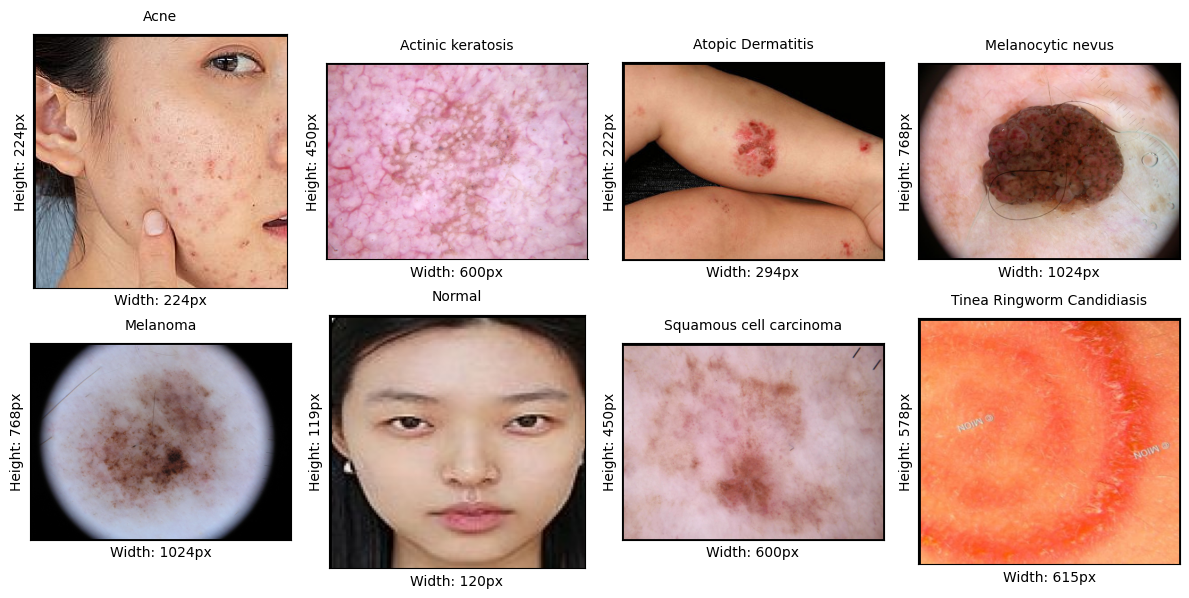

In [1]:
import os
import pathlib
from PIL import Image
import matplotlib.pyplot as plt
import random

# Path ke dataset custom (tanpa subfolder SkinDisease)
dataset = r'C:/Local D/Galeri Belajar/Project/Computer Vision/scancer/dataset/datasetfinal'

def show_gallery_one_per_class(data_dir, seed=42):
    import matplotlib.patches as patches
    import numpy as np
    random.seed(seed)
    class_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    n_classes = len(class_dirs)
    ncols = min(n_classes, 4)
    nrows = (n_classes + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3))
    if nrows == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    for i, cls in enumerate(class_dirs):
        img_list = []
        ax = axes[i]
        cls_path = os.path.join(data_dir, cls)
        img_files = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if img_files:
            img_path = os.path.join(cls_path, random.choice(img_files))
            try:
                img = Image.open(img_path)
                ax.imshow(img)
                # Tambahkan border
                rect = patches.Rectangle((0,0),img.size[0],img.size[1],linewidth=2,edgecolor='black',facecolor='none')
                ax.add_patch(rect)
                # Sumbu x/y ukuran pixel
                ax.set_xlabel(f'Width: {img.size[0]}px')
                ax.set_ylabel(f'Height: {img.size[1]}px')
                # Judul kelas di bawah
                ax.set_title(cls, fontsize=10, pad=10, loc='center')
            except Exception as e:
                ax.text(0.5, 0.5, 'Error', ha='center')
        ax.set_xticks([])
        ax.set_yticks([])
    # Kosongkan subplot sisa
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

# Contoh pemanggilan dengan seed:
print('Galeri Train:')
show_gallery_one_per_class(dataset, seed=18)

## Distribusi Jumlah Gambar per Kelas
Visualisasi berikut menunjukkan distribusi jumlah gambar pada setiap kelas di dataset train dan test. Ini penting untuk mengetahui apakah dataset seimbang atau tidak.

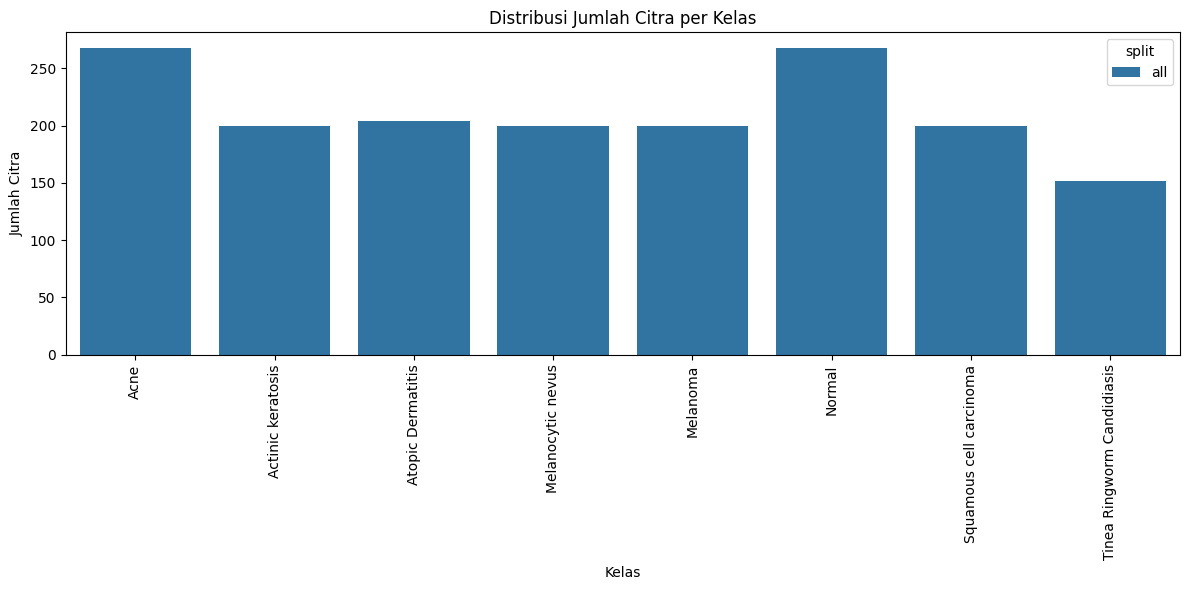

In [2]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

def count_jpg_jpeg_per_class_tf(data_dir):
    class_counts = {}
    for cls in os.listdir(data_dir):
        cls_path = os.path.join(data_dir, cls)
        if os.path.isdir(cls_path):
            files = []
            for ext in ['*.jpg', '*.jpeg', '*.JPG', '*.JPEG', '*.png', '*.PNG']:
                pattern = os.path.join(cls_path, ext)
                files.extend(tf.io.gfile.glob(pattern))
            class_counts[cls] = len(files)
    return class_counts

count_dataset = count_jpg_jpeg_per_class_tf(dataset)

df_all_tf = pd.DataFrame({'class': list(count_dataset.keys()), 'count': list(count_dataset.values()), 'split': 'all'})

plt.figure(figsize=(12,6))
sns.barplot(data=df_all_tf, x='class', y='count', hue='split')
plt.xticks(rotation=90)
plt.title('Distribusi Jumlah Citra per Kelas')
plt.ylabel('Jumlah Citra')
plt.xlabel('Kelas')
plt.tight_layout()
plt.show()

# 2. Pre-processing Process

# Split Dataset

In [4]:
import os
import shutil
import random
from tqdm import tqdm

# Path ke dataset hasil augmentasi
src_dir = dataset  # gunakan variabel dataset yang sudah ada
split_dir = r'C:/Local D/Galeri Belajar/Project/Computer Vision/scancer/dataset/dataset_split'

splits = {'train': 0.8, 'val': 0.1, 'test': 0.1}
random.seed(42)

# Buat folder split
for split in splits:
    for cls in os.listdir(src_dir):
        src_cls = os.path.join(src_dir, cls)
        if not os.path.isdir(src_cls):
            continue
        split_cls = os.path.join(split_dir, split, cls)
        os.makedirs(split_cls, exist_ok=True)

# Proses split
for cls in tqdm(os.listdir(src_dir), desc='Class'):
    src_cls = os.path.join(src_dir, cls)
    if not os.path.isdir(src_cls):
        continue
    images = [f for f in os.listdir(src_cls) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)
    n_total = len(images)
    n_train = int(splits['train'] * n_total)
    n_val = int(splits['val'] * n_total)
    n_test = n_total - n_train - n_val
    split_counts = {'train': n_train, 'val': n_val, 'test': n_test}
    idx = 0
    for split in ['train', 'val', 'test']:
        split_cls = os.path.join(split_dir, split, cls)
        for _ in range(split_counts[split]):
            img_name = images[idx]
            src_img = os.path.join(src_cls, img_name)
            dst_img = os.path.join(split_cls, img_name)
            shutil.copy2(src_img, dst_img)
            idx += 1
print('Split train/val/test selesai!')

Class: 100%|██████████| 8/8 [00:00<00:00, 11.78it/s]

Split train/val/test selesai!


## B. Augmentasi Citra
Augmentasi sangat penting untuk meningkatkan generalisasi model, terutama jika dataset terbatas atau ingin memperkaya variasi data training. Teknik yang umum digunakan: flip, rotasi, zoom, dan shift.

In [5]:
from PIL import Image, ImageEnhance, ImageOps
import random
import os
from tqdm import tqdm

def augment_pil(img, seed=42):
    """
    Fungsi augmentasi menggunakan PIL
    Returns: list of augmented images
    """
    if seed is not None:
        random.seed(seed)
    
    augmented_imgs = [img]  # Include original image

    # 1. Horizontal flip
    augmented_imgs.append(ImageOps.mirror(img))
    
    # 2. Rotation (random angle between -15 to 15 degrees)
    angle = random.uniform(-15, 15)
    augmented_imgs.append(img.rotate(angle, expand=True))
    
    # 3. SLIGHT ZOOM/CROP (simulasi jarak pengambilan foto berbeda)
    # Crop 10-15% dari tepi, lalu resize kembali ke ukuran original
    w, h = img.size
    crop_percent = random.uniform(0.05, 0.15)  # 5-15%
    crop_w = int(w * crop_percent)
    crop_h = int(h * crop_percent)
    
    cropped = img.crop((crop_w, crop_h, w - crop_w, h - crop_h))
    zoomed = cropped.resize((w, h), Image.LANCZOS)
    augmented_imgs.append(zoomed)
    
    return augmented_imgs


# Folder sumber dan folder tujuan hasil augmentasi
src_dir = 'C:\\Local D\\Galeri Belajar\\Project\\Computer Vision\\scancer\\dataset\\dataset_split\\train'  # Sudah didefinisikan sebelumnya
aug_dir = 'C:\\Local D\\Galeri Belajar\\Project\\Computer Vision\\scancer\\dataset\\dataset_split\\train_augmented'
os.makedirs(aug_dir, exist_ok=True)

for cls in tqdm(os.listdir(src_dir), desc='Class'):
    src_cls = os.path.join(src_dir, cls)
    if not os.path.isdir(src_cls):
        continue
    save_cls = os.path.join(aug_dir, cls)
    os.makedirs(save_cls, exist_ok=True)
    for img_name in tqdm(os.listdir(src_cls), desc=f'{cls}', leave=False):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        img_path = os.path.join(src_cls, img_name)
        try:
            img = Image.open(img_path)
            aug_imgs = augment_pil(img, seed=None)  # seed=None untuk variasi
            for idx, aug in enumerate(aug_imgs):
                base, ext = os.path.splitext(img_name)
                save_path = os.path.join(save_cls, f'{base}_aug{idx}{ext}')
                aug.save(save_path)
        except Exception as e:
            print(f'Error processing {img_path}: {e}')
print('Augmentasi batch selesai!')

Class: 100%|██████████| 8/8 [00:22<00:00,  2.76s/it]

Augmentasi batch selesai!


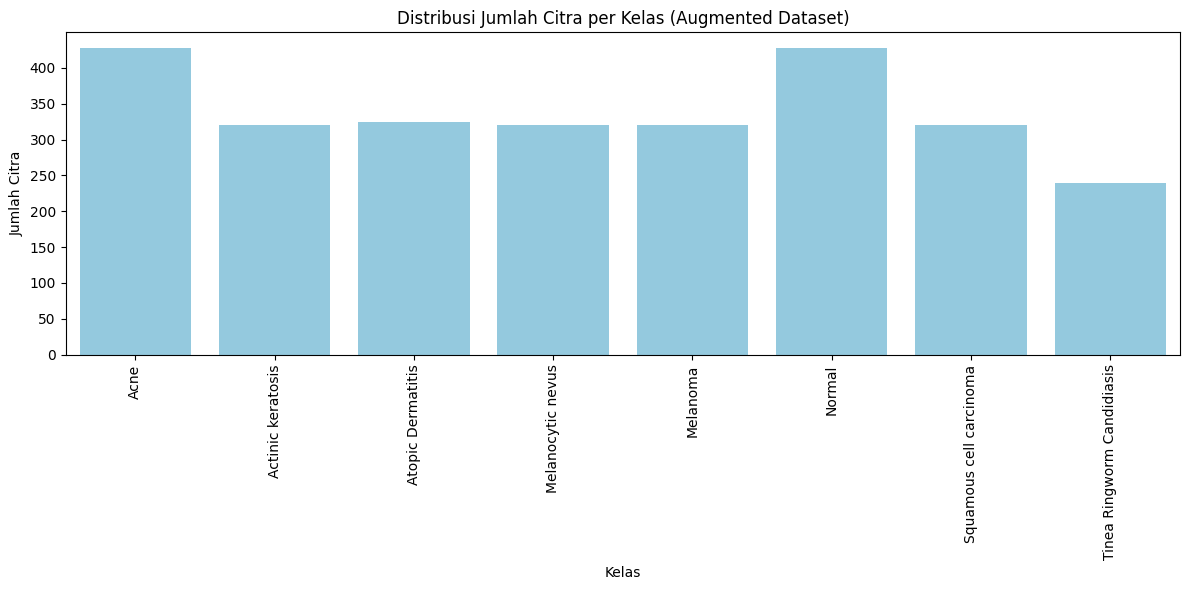

In [6]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

aug_dir = r'C:/Local D/Galeri Belajar/Project/Computer Vision/scancer/dataset/dataset_split/train_augmented'
class_counts = {}
for cls in os.listdir(aug_dir):
    cls_path = os.path.join(aug_dir, cls)
    if os.path.isdir(cls_path):
        n_imgs = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[cls] = n_imgs

# Buat DataFrame untuk visualisasi
aug_df = pd.DataFrame({'class': list(class_counts.keys()), 'count': list(class_counts.values())})
plt.figure(figsize=(12,6))
sns.barplot(data=aug_df, x='class', y='count', color='skyblue')
plt.xticks(rotation=90)
plt.title('Distribusi Jumlah Citra per Kelas (Augmented Dataset)')
plt.ylabel('Jumlah Citra')
plt.xlabel('Kelas')
plt.tight_layout()
plt.show()

# Load Model & Training

In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import timm
import os

# Path ke dataset split
split_dir = r'C:/Local D/Galeri Belajar/Project/Computer Vision/scancer/dataset/dataset_split'
train_dir = os.path.join(split_dir, 'train_augmented') # Gunakan folder augmented untuk training
val_dir = os.path.join(split_dir, 'val')

# Model & transforms
model = timm.create_model('mobilenetv4_hybrid_medium.e500_r224_in1k', 
                         pretrained=True, 
                         num_classes=len(os.listdir(train_dir)))
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

data_config = timm.data.resolve_model_data_config(model)
train_tfms = timm.data.create_transform(**data_config, is_training=True)
val_tfms = timm.data.create_transform(**data_config, is_training=False)

model.safetensors:   0%|          | 0.00/44.7M [00:00<?, ?B/s]

C:\Users\LOQ 15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LOQ 15\.cache\huggingface\hub\models--timm--mobilenetv4_hybrid_medium.e500_r224_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


# Validasi Model

In [8]:
# Datasets & loaders
train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds = datasets.ImageFolder(val_dir, transform=val_tfms)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)  # Batch size lebih kecil
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)

# Loss & optimizer dengan hyperparameter tuning
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)  # LR lebih kecil + weight decay

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-6)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Inisialisasi list untuk menyimpan metrik tiap epoch
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Training loop dengan early stopping
best_val_acc = 0
patience = 5
patience_counter = 0

for epoch in range(20):  # Lebih banyak epoch
    model.train()
    train_loss = 0
    correct_train = 0
    n_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct_train += (preds == labels).sum().item()
        n_train += images.size(0)
    train_loss /= n_train
    train_acc = correct_train / n_train
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    n_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            n_val += images.size(0)
    val_loss /= n_val
    val_acc = correct / n_val
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f'Epoch {epoch+1} Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | LR: {current_lr:.2e}')
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        # Simpan model terbaik
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

print(f"Best validation accuracy: {best_val_acc:.4f}")

Epoch 1 Train Loss: 2.8714 | Train Acc: 0.4411 | Val Loss: 1.8025 | Val Acc: 0.6386 | LR: 2.97e-05
Epoch 2 Train Loss: 1.6181 | Train Acc: 0.6252 | Val Loss: 1.6644 | Val Acc: 0.6265 | LR: 2.87e-05
Epoch 3 Train Loss: 1.2374 | Train Acc: 0.6819 | Val Loss: 1.3448 | Val Acc: 0.6867 | LR: 2.72e-05
Epoch 4 Train Loss: 1.1035 | Train Acc: 0.7119 | Val Loss: 1.9699 | Val Acc: 0.7108 | LR: 2.52e-05
Epoch 5 Train Loss: 0.9079 | Train Acc: 0.7252 | Val Loss: 1.4681 | Val Acc: 0.7349 | LR: 2.28e-05
Epoch 6 Train Loss: 0.7058 | Train Acc: 0.7915 | Val Loss: 1.5565 | Val Acc: 0.7349 | LR: 2.00e-05
Epoch 7 Train Loss: 0.7012 | Train Acc: 0.7811 | Val Loss: 0.9466 | Val Acc: 0.7831 | LR: 1.70e-05
Epoch 8 Train Loss: 0.6264 | Train Acc: 0.8019 | Val Loss: 1.2155 | Val Acc: 0.7349 | LR: 1.40e-05
Epoch 9 Train Loss: 0.5895 | Train Acc: 0.8063 | Val Loss: 0.9631 | Val Acc: 0.7590 | LR: 1.10e-05
Epoch 10 Train Loss: 0.5627 | Train Acc: 0.8144 | Val Loss: 1.1980 | Val Acc: 0.7108 | LR: 8.25e-06
Epoch 11 

In [9]:
print(len(train_accs), len(val_accs))
print(len(train_losses), len(val_losses))

12 12
12 12


# Evaluate the Model

In [10]:
# Install plotly if not available
try:
    import plotly.express as px
except ImportError:
    import sys
    !{sys.executable} -m pip install plotly
    import plotly.express as px

from sklearn.metrics import classification_report
import numpy as np

# Path ke test set
test_dir = os.path.join(split_dir, 'test')
test_ds = datasets.ImageFolder(test_dir, transform=val_tfms)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

# Plot Accuracy
acc = pd.DataFrame({'train_acc': train_accs, 'val_acc': val_accs})
fig_acc = px.line(acc, x=acc.index + 1, y=acc.columns, title='Training and Validation Accuracy per Epoch', markers=True)
fig_acc.update_layout(xaxis_title='Epoch', yaxis_title='Accuracy')
fig_acc.show()

# Plot Loss
loss = pd.DataFrame({'train_loss': train_losses, 'val_loss': val_losses})
fig_loss = px.line(loss, x=loss.index + 1, y=loss.columns, title='Training and Validation Loss per Epoch', markers=True)
fig_loss.update_layout(xaxis_title='Epoch', yaxis_title='Loss')
fig_loss.show()

# Evaluate on test set
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

# Classification report
class_names = test_ds.classes
print(classification_report(y_true, y_pred, target_names=class_names))

                            precision    recall  f1-score   support

                      Acne       1.00      0.93      0.96        14
         Actinic keratosis       0.78      0.70      0.74        10
         Atopic Dermatitis       0.75      0.82      0.78        11
         Melanocytic nevus       0.78      0.70      0.74        10
                  Melanoma       0.78      0.70      0.74        10
                    Normal       1.00      1.00      1.00        14
   Squamous cell carcinoma       0.54      0.70      0.61        10
Tinea Ringworm Candidiasis       0.89      0.89      0.89         9

                  accuracy                           0.82        88
                 macro avg       0.81      0.80      0.81        88
              weighted avg       0.83      0.82      0.82        88



In [12]:
import torch
import os
import json
from datetime import datetime

# Debug: Cek nilai akurasi sebelum menyimpan
print("=== DEBUG INFO ===")
print(f"Train accs length: {len(train_accs) if 'train_accs' in locals() else 'Not defined'}")
print(f"Val accs length: {len(val_accs) if 'val_accs' in locals() else 'Not defined'}")
if 'train_accs' in locals() and train_accs:
    print(f"Last 3 train accs: {train_accs[-3:]}")
if 'val_accs' in locals() and val_accs:
    print(f"Last 3 val accs: {val_accs[-3:]}")
print(f"Best val accuracy: {best_val_acc if 'best_val_acc' in locals() else 'Not defined'}")
print("=================")

# Buat folder dan path
model_dir = r'C:/Local D/Galeri Belajar/Project/Computer Vision/scancer/model'
os.makedirs(model_dir, exist_ok=True)

# Nama file dengan timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = os.path.join(model_dir, f'mobilenetv4_scancer_{timestamp}.pth')
config_path = os.path.join(model_dir, f'model_config_{timestamp}.json')

# Simpan model
torch.save(model.state_dict(), model_path)

# Model info - simple dan bersih
model_info = {
    # Model details
    'model_name': 'mobilenetv4_hybrid_medium.e500_r224_in1k',
    'architecture': 'MobileNetV4 Hybrid Medium',
    'num_classes': len(train_ds.classes),
    'class_names': list(train_ds.classes),
    
    # Input preprocessing
    'input_size': [224, 224, 3],
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225],
    
    # Training results
    'best_val_accuracy': float(best_val_acc),
    'final_train_accuracy': float(train_accs[-1]) if train_accs else 0.0,
    'final_val_accuracy': float(val_accs[-1]) if val_accs else 0.0,
    'test_accuracy': 0.82,  # Dari classification report
    
    # Training config
    'training_epochs': len(train_accs) if train_accs else 0,
    'batch_size': 16,
    'optimizer': 'AdamW',
    'learning_rate': 3e-5,
    
    # Metadata
    'created_at': datetime.now().isoformat(),
    'framework': 'PyTorch'
}

# Simpan konfigurasi
with open(config_path, 'w') as f:
    json.dump(model_info, f, indent=2)

# Hasil
model_size_mb = round(os.path.getsize(model_path) / (1024*1024), 2)

print("="*40)
print("✅ MODEL BERHASIL DISIMPAN!")
print("="*40)
print(f"📁 Model: {model_path}")
print(f"📄 Config: {config_path}")
print(f"📊 Size: {model_size_mb} MB")
print()
print("🎯 PERFORMANCE:")
print(f"   Best Val Acc: {model_info['best_val_accuracy']:.4f} ({model_info['best_val_accuracy']*100:.2f}%)")
print(f"   Test Acc: {model_info['test_accuracy']:.4f} ({model_info['test_accuracy']*100:.2f}%)")
print()
print("🏷️  CLASSES:")
for i, class_name in enumerate(model_info['class_names']):
    print(f"   {i}: {class_name}")
print("="*40)

=== DEBUG INFO ===
Train accs length: 12
Val accs length: 12
Last 3 train accs: [0.8144444444444444, 0.82, 0.8177777777777778]
Last 3 val accs: [0.7108433734939759, 0.7831325301204819, 0.7590361445783133]
Best val accuracy: 0.7831325301204819
✅ MODEL BERHASIL DISIMPAN!
📁 Model: C:/Local D/Galeri Belajar/Project/Computer Vision/scancer/model\mobilenetv4_scancer_20250923_164539.pth
📄 Config: C:/Local D/Galeri Belajar/Project/Computer Vision/scancer/model\model_config_20250923_164539.json
📊 Size: 37.92 MB

🎯 PERFORMANCE:
   Best Val Acc: 0.7831 (78.31%)
   Test Acc: 0.8200 (82.00%)

🏷️  CLASSES:
   0: Acne
   1: Actinic keratosis
   2: Atopic Dermatitis
   3: Melanocytic nevus
   4: Melanoma
   5: Normal
   6: Squamous cell carcinoma
   7: Tinea Ringworm Candidiasis
